In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Read Data

In [111]:
tasks = pd.read_csv('data/task_report_10.csv')
task_detail = pd.read_csv('data/task_10.csv')
projects = pd.read_csv('data/project_report_10.csv')

# Convert to datetime
tasks['Date'] = pd.to_datetime(tasks['Date'])
tasks['StartDate'] = pd.to_datetime(tasks['StartDate'])
tasks['EndDate'] = pd.to_datetime(tasks['EndDate'])
tasks['ActualStartDate'] = pd.to_datetime(tasks['ActualStartDate'])
tasks['ActualEndDate'] = pd.to_datetime(tasks['ActualEndDate'])

## Helper Function

In [112]:
def calculate_depth(row):
    depth = 1 
    parent_id = row['ParentTaskID']
    while not pd.isna(parent_id):
        depth += 1
        parent_id = task_detail.loc[task_detail['ID'] == int(parent_id), 'ParentTaskID'].iloc[0]
    return depth

## Exploratory Data Analysis

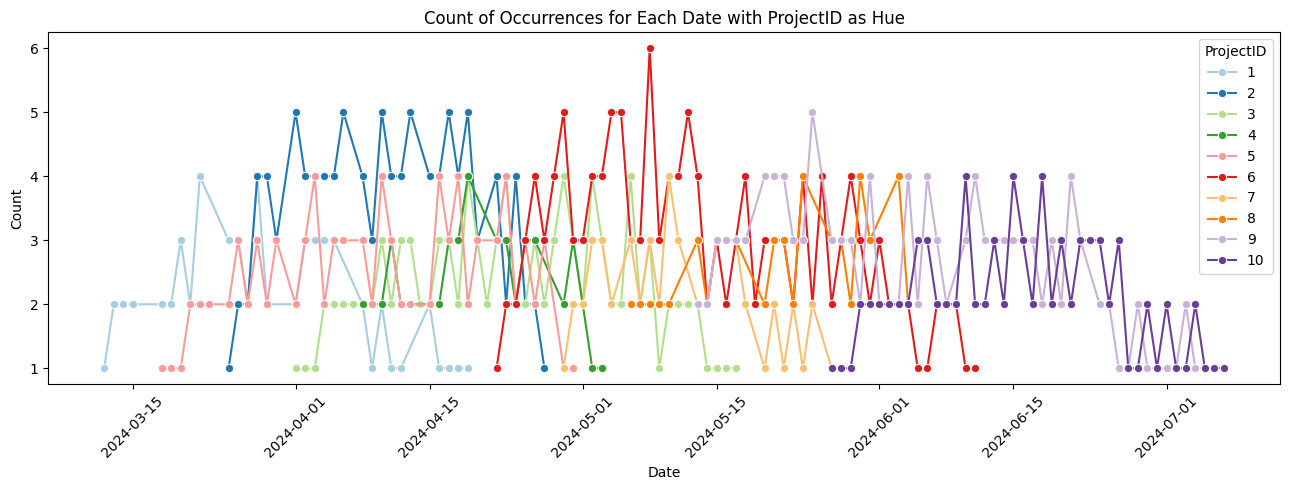

In [113]:
date_counts = tasks.groupby(['Date', 'ProjectID']).size().reset_index(name='Count')

# Plotting with Seaborn
plt.figure(figsize=(13, 5))
sns.lineplot(data=date_counts, x='Date', y='Count', hue='ProjectID', marker='o', palette='Paired')
plt.title('Count of Occurrences for Each Date with ProjectID as Hue')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [114]:
project_counts = tasks.groupby(['ProjectID','ID']).size().reset_index(name='Count')
project_counts = project_counts.groupby('ProjectID').agg({'ID':'count','Count':'sum'}).reset_index()
project_counts = project_counts.astype(int)
project_counts['AvgDaysPerTask'] = (project_counts['Count'] / project_counts['ID']).round(2)

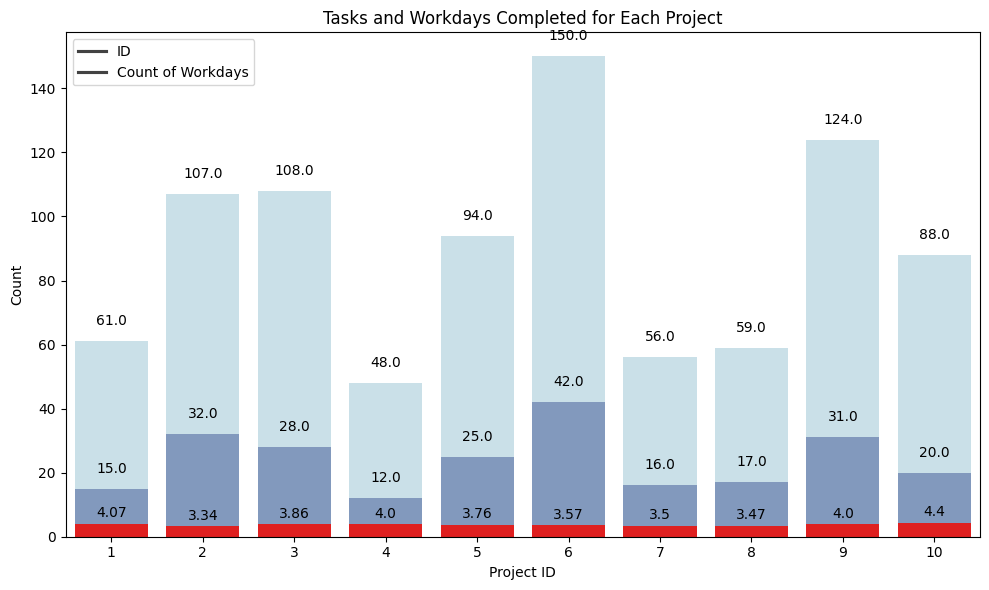

In [115]:
plt.figure(figsize=(10, 6))
sns.barplot(data=project_counts, x='ProjectID', y='ID', color='navy')
sns.barplot(data=project_counts, x='ProjectID', y='Count', color='lightblue', alpha=0.7)
sns.barplot(data=project_counts, x='ProjectID', y='AvgDaysPerTask', color='red')

# Adding count labels on top of the bars
for index, row in project_counts.iterrows():
    plt.text(row.name, row['ID'] + 5, row['ID'], color='black', ha="center")
    plt.text(row.name, row['Count'] + 5, row['Count'], color='black', ha="center")
    plt.text(row.name, row['AvgDaysPerTask'] + 2, row['AvgDaysPerTask'], color='black', ha="center")

plt.title('Tasks and Workdays Completed for Each Project')
plt.xlabel('Project ID')
plt.ylabel('Count')
plt.legend(['ID', 'Count of Workdays'], loc='upper left')
plt.tight_layout()
plt.show()

## Feature Engineering

In [116]:
# Task completion rate in percentage (progress/duration)
tasks['CompletionRate'] = tasks['Progress']/tasks['Duration']*100

# How many days delayed from actual start date
tasks['StartDelay'] = (tasks['ActualStartDate'] - tasks['StartDate']).dt.days

# How many days have passed since the planned start date
tasks['DayCount'] = (tasks['Date']-tasks['StartDate']).dt.days 

# How many days the tasks are delayed from planned time
TaskDelay = (tasks.groupby('ID')['Duration'].count()-tasks.groupby('ID')['Duration'].mean().astype(int)).reset_index(name='TaskDelay')
tasks = pd.merge(tasks,TaskDelay,on='ID',how='left')

# How many tasks today in the same project
TaskToday = tasks.groupby('Date')['ID'].count().reset_index(name='TaskToday')
tasks = pd.merge(tasks,TaskToday,on='Date',how='left')

# How long the task until the root task
TaskParent = task_detail.apply(calculate_depth, axis=1).reset_index(name='TaskParent')
TaskParent.rename(columns={'index':'ID'},inplace=True)
TaskParent['ID']+=1
tasks = pd.merge(tasks,TaskParent,on='ID',how='left')

In [117]:
# Use project ID 10 as test set
test_idx = tasks.loc[tasks['ProjectID']==10].index.tolist()

In [118]:
# Remove unnecessary Columns
tasks_df =  tasks.drop(columns=['Date','ID','ProjectID','Name','StartDate','EndDate','ActualStartDate','ActualEndDate'])

In [119]:
tasks_df['Priority'] = tasks_df['Priority'].apply(lambda x: 1 if x=='Critical' else 0)
status_ohe = pd.get_dummies(tasks_df['Status'], prefix='Is').astype(int)
tasks_df = pd.concat([tasks_df, status_ohe], axis=1)
tasks_df.drop(columns='Status', inplace=True)
tasks_df = tasks_df.astype(float)

In [120]:
columns = tasks_df.columns.tolist()
target = 'TaskDelay'
features = columns.copy()
features.remove(target)

<Axes: >

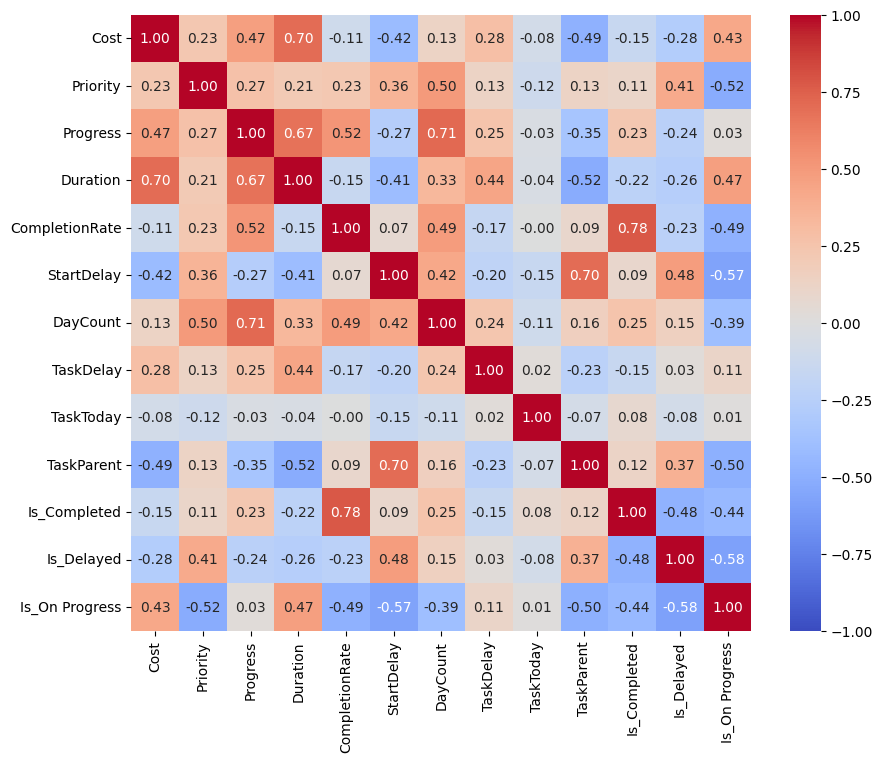

In [121]:
plt.figure(figsize=(10, 8))
sns.heatmap(tasks_df.corr(), vmin=-1, vmax=1, annot=True, fmt=".2f",cmap='coolwarm')

<Axes: >

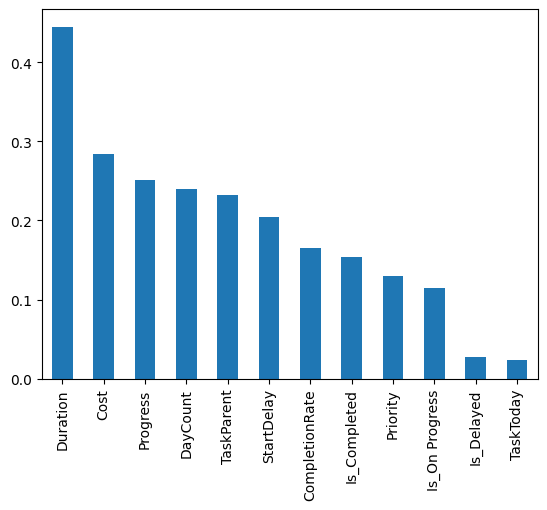

In [122]:
tasks_df.corr()['TaskDelay'].abs().sort_values(ascending=False).iloc[1:].plot(kind='bar')

## Model Development

In [123]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor

In [124]:
X = tasks_df.copy()
y = X.pop(target)

X_train = X[~X.index.isin(test_idx)]
y_train = y[~y.index.isin(test_idx)]
X_test = X[X.index.isin(test_idx)]
y_test = y[y.index.isin(test_idx)]

# Creating and training the decision tree regression model
model = DecisionTreeRegressor(max_depth=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_pred)
print("Train MAE :", mae_train, " | Test MAE : ", mae_test)

Train MAE : 0.3425748282382426  | Test MAE :  0.9422798507475373


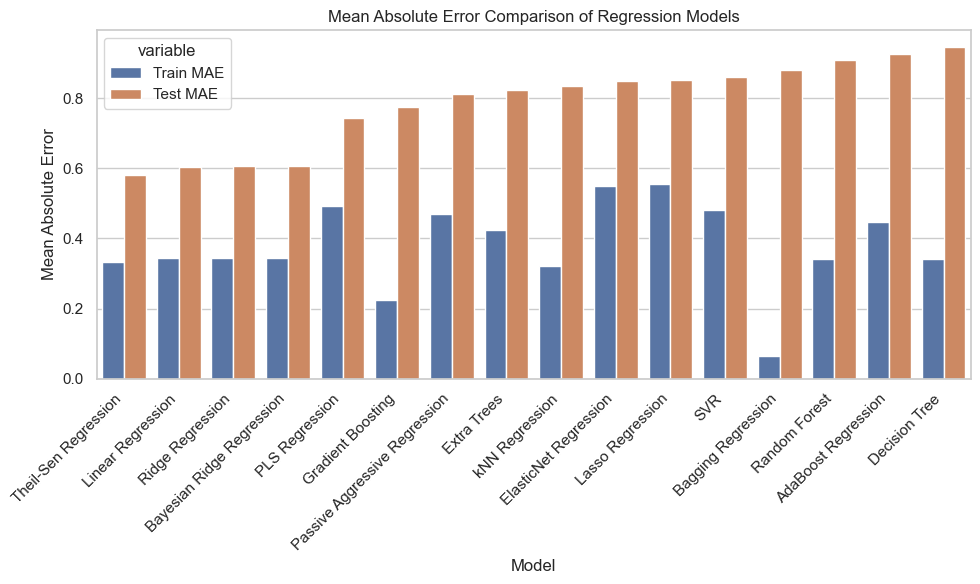

In [142]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, HuberRegressor, PassiveAggressiveRegressor, TheilSenRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor

def evaluate_regression_models(X_train, y_train, X_test, y_test):
    models = {
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(),
        "Lasso Regression": Lasso(),
        "ElasticNet Regression": ElasticNet(),
        "SVR": SVR(),
        "kNN Regression": KNeighborsRegressor(),
        "Decision Tree": DecisionTreeRegressor(max_depth=5),
        "Random Forest": RandomForestRegressor(max_depth=5),
        "Extra Trees": ExtraTreesRegressor(max_depth=5),
        "Gradient Boosting": GradientBoostingRegressor(),
        "Bagging Regression": BaggingRegressor(),
        "AdaBoost Regression": AdaBoostRegressor(),
        "PLS Regression": PLSRegression(),
        "Bayesian Ridge Regression": BayesianRidge(),
        "Passive Aggressive Regression": PassiveAggressiveRegressor(),
        "Theil-Sen Regression": TheilSenRegressor()
    }
    
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        mae_train = mean_absolute_error(y_train, y_train_pred)
        mae_test = mean_absolute_error(y_test, y_test_pred)
        results.append({"Model": name, "Train MAE": mae_train, "Test MAE": mae_test})
    
    return pd.DataFrame(results)

# Assuming X_train, y_train, X_test, y_test are defined
results_df = evaluate_regression_models(X_train, y_train, X_test, y_test)
results_df.sort_values(by='Test MAE', inplace=True)

# Plotting using seaborn
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=results_df.melt(id_vars="Model"), x="Model", y="value", hue="variable")
ax.set_title('Mean Absolute Error Comparison of Regression Models')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()